Best parameters noted in the notebook.
Update this notebook before uploading

Deep Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler


import torch
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
# from utils.helper import fn_plot_tf_hist

In [2]:
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()


In [3]:
### ----------------------
### global variables
### ----------------------


import random

RANDOM_STATE = 24
np.random.RandomState(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 100  # NUMBER OF ITERATIONS
BATCH_SIZE = 128

PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 10


# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Data

In [11]:
data_df = pd.read_csv("fashion-mnist_train.csv")
data_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
class_names = {0 : "T-shirt",
               1 : "Trousers",
               2 : "long sleeves",
               3 : "dress",
               4 : "hoodie",
               5 : "sandle",
               6 : "shirt",
               7 : "sneaker",
               8 : "bag",
               9 : "boot"}

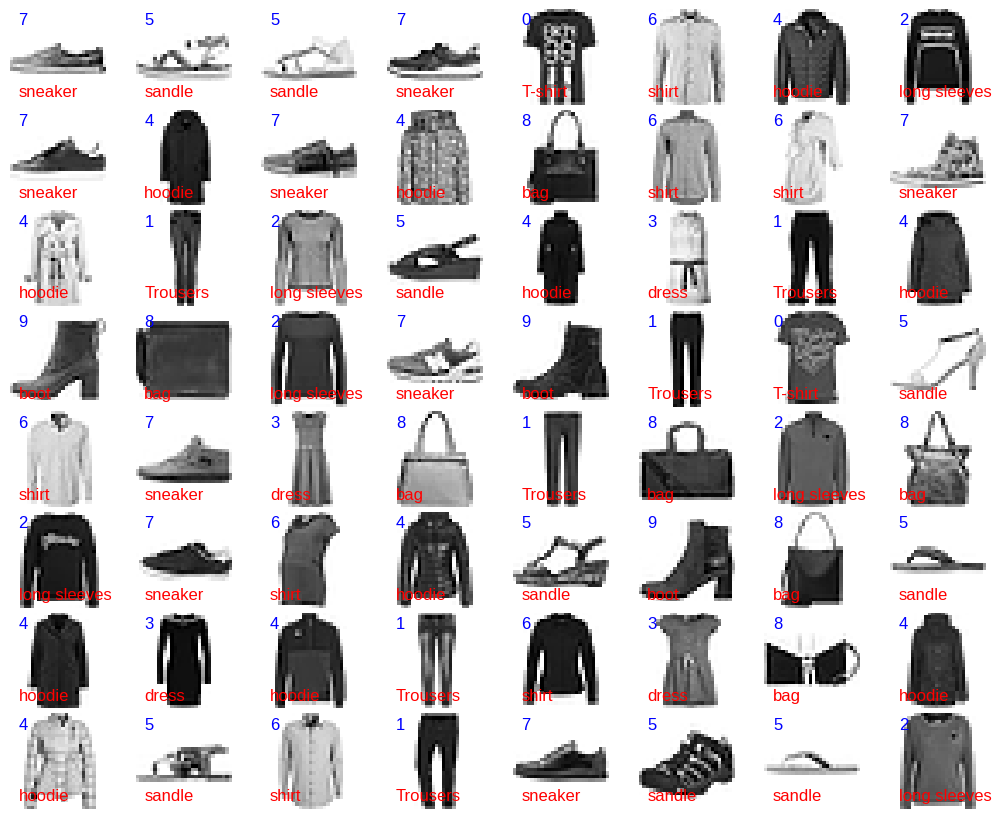

In [27]:
n_rows = 8 # Number of rows in grid
n_cols = 8 # Number of columns in grid

# Randomly sample n_rows * n_cols images from dataset
plot_df= data_df.sample(n = n_rows *  n_cols)

# create new figure with larger grid
fig = plt.figure(figsize = (10, 8))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# subplot index
i = 0

# Iterate on each row
for idx, row in plot_df.iterrows():
    i += 1  # Increment subplot index.

    # reshape the row values (excluding the first column) into a 28 x 28 matrix
    image = row.values[1:].reshape(28, 28)

    # add a subplot to the figure at the 'i'th position in the grid
    ax = fig.add_subplot(n_rows, n_cols, i, xticks = [], yticks = [])

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = "nearest")

    # add the numeric label of the image in blue text at a specific position
    ax.text(2, 4, str(row.iloc[0]), color = "b", fontsize = 12)

    # add the class name of the image in red text below the nmeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = "r", fontsize = 12)

# display the entire grid of images
plt.show()

In [12]:
x_train_cols = data_df.drop(["label"], axis = 1)
y_train_cols = data_df["label"].to_numpy()
x_train_cols.shape, y_train_cols.shape

((60000, 784), (60000,))

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_train_cols,
                                                    y_train_cols,
                                                    test_size = 0.2,
                                                    random_state = 24,
                                                    stratify = y_train_cols)

In [14]:
sc = StandardScaler()

x_train = sc.fit_transform(x_train, y_train)
x_test = sc.transform(x_test)

In [7]:
test_df = pd.read_csv("fashion-mnist_test.csv")
x_valid = test_df.drop("label", axis = 1).to_numpy()
y_valid = test_df["label"].to_numpy()

x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,))

In [15]:
class MnistDataset(Dataset):
    def __init__(self, x, y):
        super(MnistDataset, self).__init__()
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.long)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [17]:
train_dataset = MnistDataset(x_train, y_train)
train_loader = DataLoader(dataset = train_dataset,
                          shuffle = True,
                          batch_size = BATCH_SIZE)

x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 784]), torch.Size([128]))

In [18]:
test_dataset = MnistDataset(x_test, y_test)
test_loader = DataLoader(dataset = test_dataset,
                          shuffle = True,
                          batch_size = BATCH_SIZE)

x_batch, y_batch = next(iter(test_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 784]), torch.Size([128]))

In [19]:
torch.cuda.is_available()

False

In [21]:
import torch.version

torch.version.cuda

'12.1'

In [24]:
# torch.cuda.get_device_name(torch.cuda.current_device())

In [23]:
device = 'cpu'

In [25]:
x_train.shape, x_test.shape

((48000, 784), (12000, 784))

In [41]:
input_dim = x_train.shape[1]

class Model(nn.Module):

    # Droupout
    # BatchNorm

    def __init__(self, input_dim):
        super(Model, self).__init__()
        dor1 = 0.4
        dor2 = 0.3
        dor3 = 0.2
        dor4 = 0.15

        # Set 1
        self.layer1 = nn.Linear(input_dim,1280)
        self.actv1 = nn.ReLU()
        self.do1 = nn.Dropout(dor1)
        self.bn1 = nn.BatchNorm1d(1280)

        # Set 2
        self.layer2 = nn.Linear(1280,640)
        self.actv2 = nn.ReLU()
        self.do2 = nn.Dropout(dor2)
        self.bn2 = nn.BatchNorm1d(640)

        # Set 3
        self.layer3 = nn.Linear(640,320)
        self.actv3 = nn.ReLU()
        self.do3 = nn.Dropout(dor3)
        self.bn3 = nn.BatchNorm1d(320)

        # Set 4
        self.layer4 = nn.Linear(320,160)
        self.actv4 = nn.ReLU()
        self.do4 = nn.Dropout(dor4)
        self.bn4 = nn.BatchNorm1d(160)

        # Set 5
        self.layer5 = nn.Linear(160,80)
        self.actv5 = nn.ReLU()
        self.do5 = nn.Dropout(dor4)
        self.bn5 = nn.BatchNorm1d(80)


        self.layer6 = nn.Linear(80, 10)

    def forward(self, x):
        # Set 1
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.do1(x)

        # Set 2
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.do2(x)

        # Set 3
        x = self.layer3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.do3(x)

        # Set 4
        x = self.layer4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        x = self.do4(x)

        # Set 5
        x = self.layer5(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.do5(x)

        # Set 6
        x = self.layer6(x)
        return x

model = Model(input_dim).to(device = device)

print(model)

# model = nn.keras.Sequential([
#     tf.keras.Input(nn.Linear(input_dim, 18),
#                    nn.ReLU(),
#                    nn.Linear(18,4).to(device = device)),            # input layer
#     tf.keras.layers.Dense(18, activation = tf.nn.relu, name = "fc_1"),   # Layer 1
#     tf.keras.layers.Dense(4, name = "output")
# ])

Model(
  (layer1): Linear(in_features=784, out_features=1280, bias=True)
  (actv1): ReLU()
  (do1): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=1280, out_features=640, bias=True)
  (actv2): ReLU()
  (do2): Dropout(p=0.3, inplace=False)
  (bn2): BatchNorm1d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=640, out_features=320, bias=True)
  (actv3): ReLU()
  (do3): Dropout(p=0.2, inplace=False)
  (bn3): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer4): Linear(in_features=320, out_features=160, bias=True)
  (actv4): ReLU()
  (do4): Dropout(p=0.15, inplace=False)
  (bn4): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer5): Linear(in_features=160, out_features=80, bias=True)
  (actv5): ReLU()
  (do5): Dropout(p=0.15, inplace=False)
  (bn5): BatchNorm1

In [42]:
for param in list(model.parameters()):
    print(param.shape)

torch.Size([1280, 784])
torch.Size([1280])
torch.Size([1280])
torch.Size([1280])
torch.Size([640, 1280])
torch.Size([640])
torch.Size([640])
torch.Size([640])
torch.Size([320, 640])
torch.Size([320])
torch.Size([320])
torch.Size([320])
torch.Size([160, 320])
torch.Size([160])
torch.Size([160])
torch.Size([160])
torch.Size([80, 160])
torch.Size([80])
torch.Size([80])
torch.Size([80])
torch.Size([10, 80])
torch.Size([10])


In [43]:
# del model

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode = 'min',
                                                       factor = LR_FACTOR,
                                                       patience = LR_PATIENCE,
                                                       min_lr = 1e-5)
# Some lists t ocollect progress
loss, tloss, n_epoch, acc, tacc = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train() # mode = train
    epoch_loss = 0
    epoch_acc = 0
    tepoch_loss = 0
    tepoch_acc = 0
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        predict_proba = model(train_x)
        batch_loss = loss_fn(predict_proba, train_y)
        epoch_loss += (batch_loss - epoch_loss)/ (batch_idx+1)

        # Backpropogation

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        y_pred = predict_proba.argmax(dim = 1).cpu().numpy()
        batch_acc = accuracy_score(train_y.cpu().numpy(), y_pred)
        epoch_acc += (batch_acc - epoch_acc)/ (batch_idx + 1)

    loss.append(epoch_loss.data.item())
    # _, y_pred = torch.max(predict_proba, 1)
    # curr_acc = accuracy_score(y_train_tensor.cpu().numpy(), y_pred.data.cpu())
    acc.append(epoch_acc)

    model.eval() # mode = predict

    for batch_idx, (test_x, test_y) in enumerate(test_loader):
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_proba = model(test_x)
        batch_loss = loss_fn(test_proba, test_y)
        tepoch_loss += (batch_loss - tepoch_loss)/(batch_idx + 1)
        y_pred = test_proba.argmax(dim = 1).cpu().numpy()
        batch_acc = accuracy_score(test_y.cpu().numpy(), y_pred)
        tepoch_acc += (batch_acc - tepoch_acc)/ (batch_idx + 1)

    tacc.append(tepoch_acc)
    tloss.append(tepoch_loss.data.item())
    n_epoch.append(epoch)

    # LR Reduction step
    scheduler.step(tepoch_loss)

    if epoch % 5 == 0:
        print(f"Epoch: {epoch: > 5d} | loss : {epoch_loss} / {tepoch_loss:.5f}")
        print(f"Acc : {epoch_acc:.5f} / {tepoch_acc:.5f}")
        print(f'LR : {scheduler.get_last_lr()[0]:.5f}')



Epoch:     0 | loss : 0.6138573288917542 / 0.40327
Acc : 0.79933 / 0.85431
LR : 0.00100


In [44]:
loss_df = pd.DataFrame({'epoch' : n_epoch,
                        'loss' : loss,
                        'test_loss' : tloss,
                        'acc' : acc,
                        'test_acc' : tacc
                        })

loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,0.613857,0.403272,0.799333,0.854305
1,1,0.429755,0.395007,0.849875,0.858073
2,2,0.390065,0.354732,0.861833,0.868490
3,3,0.363829,0.341255,0.870375,0.874889
4,4,0.345400,0.341370,0.876542,0.875776


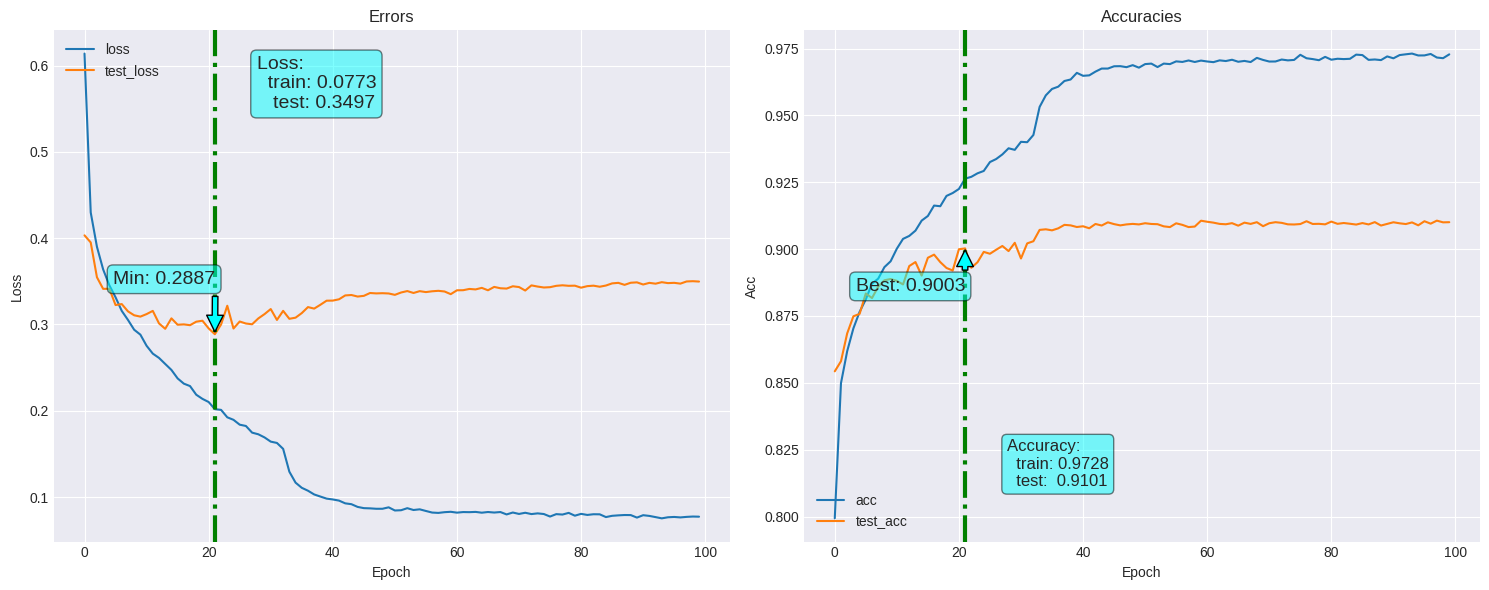

In [45]:
fn_plot_torch_hist(loss_df)

Performance of model on Train Dataset

In [46]:
outputs = model(train_x)
y_pred = torch.argmax(outputs, dim = 1).cpu().detach().numpy()

In [47]:
y_true = train_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        14
           6       1.00      0.92      0.96        13
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        15

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128



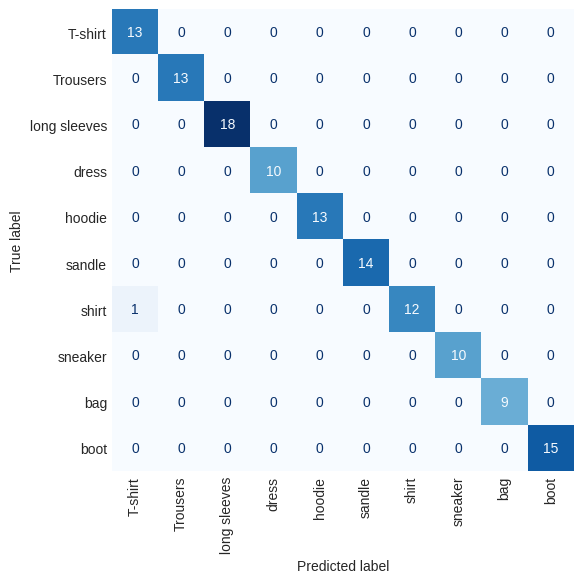

In [48]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)

Performance of Model on Test Dataset

In [49]:
outputs = model(test_x)
y_pred = torch.argmax(outputs, dim = 1).cpu().detach().numpy()

In [50]:
y_true = test_y.cpu().numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        12
           2       0.79      0.92      0.85        12
           3       0.83      0.62      0.71         8
           4       0.62      0.80      0.70        10
           5       1.00      1.00      1.00        11
           6       1.00      0.78      0.88         9
           7       1.00      1.00      1.00        10
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         9

    accuracy                           0.91        96
   macro avg       0.92      0.89      0.90        96
weighted avg       0.92      0.91      0.91        96



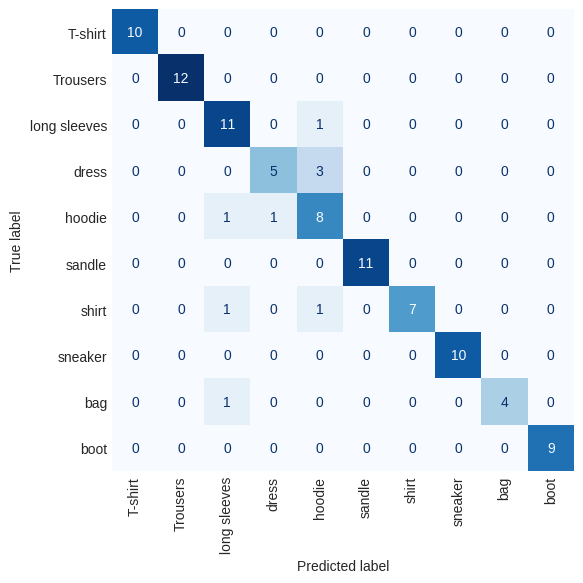

In [51]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names.values())
disp.plot(cmap = 'Blues', xticks_rotation = 'vertical', colorbar = False)
plt.grid(False)